# Finite Difference method for solving discrete Laplace Equation

### Exercise 1: solve the 4x4 linear equation A.x = b

`4*u[i,j] - u[i-1,j] - u[i+1,j] - u[i,j-1] - u[i,j+1] = 0`

Dervie and solve the linear system A.x =b

REF: https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html#scipy.linalg.solve

In [29]:
%reset -f

import numpy as np
from scipy import linalg
from scipy.sparse import csc_matrix
import scipy.sparse.linalg as splinalg

In [30]:
# a = np.array([[4, -1, -1, 0], [-1, 4, 0, -1], [-1, 0, 4, -1], [0, -1, -1, 4]])
# b = np.array([0, 0, 1, 1])

# x = linalg.solve(a, b).reshape(2, 2)
# print(x)

### Exercise 2: arbitrary size of the matrix.

If we want our solve could sovle an arbitrary size of the system NxN in 2D.\
First, we need to generate the left-hand matrix. \
The left-hand matrix contains two components: One is an diagnoal matrix with only three banded values.\
The other component conatins negative identity matrice.\

we could use the `dia_matrix` in `scipy.sparse` and `np.identity()` for these components.

REF: https://docs.scipy.org/doc/scipy/reference/sparse.html

In [31]:
import numpy as np
from scipy.sparse import dia_array
from numba import jit, njit, prange
from scipy.sparse import dia_matrix

In [32]:
N = 64
min, max = -1, 1
dx = (max - min) / N

Part 1: 

Write a function to generate the matrxi A with arbitrary size N.

Hints: depedning on your implmentation, you might want to use `numba` to speed it up.

In [33]:
def generate_D(n):
    ex = np.ones(n)
    data = np.array([-1 * ex, 4 * ex, -1 * ex])
    offsets = np.array([-1, 0, 1])
    
    return dia_matrix((data, offsets), shape=(n, n)).toarray()

In [34]:
@njit(parallel = True)
def kernel(N, A, D, I):
    for i in prange(N):
        for j in prange(N):
            if i == j:
                for ii in prange(N):
                    for jj in prange(N):
                        A[ii+N*i, jj+N*j] = D[ii, jj]
                        
            if np.abs(i - j) == 1:
                for ii in prange(N):
                    for jj in prange(N):
                        A[ii+N*i, jj+N*j] = I[ii, jj]
                        
    return A

In [35]:
def generate_A(N):
    A = np.zeros((N ** 2, N ** 2))
    D = generate_D(N)
    I = -np.identity(N)
    A = kernel(N, A, D, I)
    return A

Part2:

The right hand side of the lienar equation is a vecotr.\
generate a vecotr is simple with `np.array()`

In [36]:
def rho(x, y):
    val = np.exp(-10 * np.sqrt(x**2 + y**2))
    return val

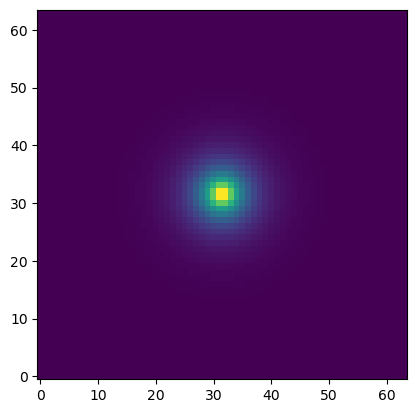

In [37]:
def generate_g(N, rho, min, max):
    g = np.array([])
    n = np.linspace(min, max, N)
    for i in n:
        for j in n:
            g = np.append(g, rho(i, j))
    
    return g

# meshgrid !!! go to use :)

# checking
import matplotlib.pyplot as plt
plt.imshow(generate_g(64, rho, min, max).reshape(64, 64), origin = 'lower')

In [38]:
def generate_b(N, g, dx):
    b = np.zeros(N ** 2)
    # b[-N:] = 1
    # b = b - g * np.square(dx) 
    b = - g * np.square(dx)
    return b

In [39]:
a = np.array([0, 1, 2, 3, 4])
print(a[-2:]) # from -2 to the end

[3 4]


Part 3:

Once we have the linear problem `A x = b`, we could solve the system with `scipy.linalg.solve` 

REF: https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html#scipy.linalg.solve

In [40]:
from scipy import linalg

In [41]:
# solve
def solve(N, rho, dx):
    g = generate_g(N, rho, min, max)
    a = generate_A(N)
    a = csc_matrix(a) # transform to the fitting matrix
    b = generate_b(N, g, dx)
    x = splinalg.spsolve(a, b).reshape(N, N)
    return x

Part 4:

Once we have the solution, we should convert the solution vector to the finite difference grids `u[i,j]`.

In [42]:
u = solve(N, rho, dx)

Part 5:

Now, let's visualize the solution with `matplotlib`

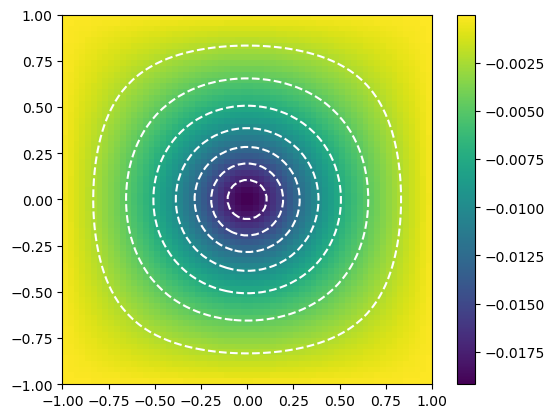

In [43]:
import matplotlib.pyplot as plt
plt.imshow(u, origin = 'lower', extent=[-1, 1, -1, 1])
plt.colorbar()
plt.contour(u, colors = 'white', extent=[-1, 1, -1, 1])

Part 6:

Now we have tested our code, we could write a "solver" function to wrap all necessary codes.\
This solver function could be either in the notebook or in a seperate python file.

In [44]:
#  as above

Part 7:

The buttole neck of this solver is in the `linalg.solve()`.\
Let's measure the performance of `linalg.solve()` with different resolutions.

In [45]:
# import time

In [46]:
# size = np.array([8, 16, 32, 64, 128])
# T = np.zeros(0)
# for i in size:
#     t1 = time.time()
#     solve(i, rho, dx)
#     t2 = time.time()
#     t = t2 - t1
#     print(t)
#     T = np.append(T, t)

In [47]:
# plt.plot(T, '--o')
# plt.xscale('log')
# plt.yscale('log')

Part 8:

Plot Computing time vs N in log-log scale.

In [48]:
# as above

You could see that the perofmance is propotional to `N^5`!\
This is becasue the size of the matrix A is proportional to `N^2` and\
the calculation time of `linalg.solve(M,b)` is proportial to the cubic of the size of M, N^3,\
giving `N^5` at the end.

The `scipy.linalg.solve` is robust, but since the matrix A is a sparse matrix, we could use special method to solve it.

REF: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.spsolve.html

In [49]:
# from scipy.sparse import csc_matrix
# import scipy.sparse.linalg as splinalg

In [50]:
# # solve
# def spsolve(N):
#     a = generate_A(N)
#     b = generate_b(N)
#     a = csc_matrix(a) # transform to the fitting matrix
#     x = splinalg.spsolve(a, b).reshape(N, N)
#     return x

Let's measure the performance again with `spsolve()`

In [51]:
# size = np.array([8, 16, 32, 64, 128])
# T = np.zeros(0)
# for i in size:
#     t1 = time.time()
#     spsolve(i)
#     t2 = time.time()
#     t = t2 - t1
#     print(t)
#     T = np.append(T, t)

You got several oreders of speedup if you know the matrix is a sparse matrix.

In [52]:
# plt.plot(T, '--o')
# plt.xscale('log')
# plt.yscale('log')